# Statistical analysis

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

d = pd.read_csv("data-processed.csv")

## Participants

In [33]:
print("Number of participants:")
print(len(d["Participant ID"].unique()))
print()
print("Native vs. non-native:")
#print(d["Native"].value_counts())
print()
print("Different kinds of designers:")
#print(d["Designer"].value_counts())


Number of participants:
21

Native vs. non-native:

Different kinds of designers:


## JoM for categories of designers

In [18]:
display(d.groupby("Designer")["JoM"].mean())

JoM for categories of designers


Designer
Non-designer      45.416667
Other designer    48.333333
Name: JoM, dtype: float64

## JoL for categories of designers

In [19]:
display(d.groupby("Designer")["JoL"].value_counts())

JoL for categories of designers


Designer        JoL                   
Non-designer    easy to read              396
                difficult to read         360
                very easy to read         288
                ok                        144
                very difficult to read    108
Other designer  difficult to read          72
                ok                         72
                easy to read               36
                very easy to read          36
Name: JoL, dtype: int64

## Calculating p(A)

# Lexical task, font: sansforgetica


counts  frequencies
categories responses                             
word       Sure word           209.0     0.995238
           Probably word         1.0     0.004762
           Probably non-word     0.0     0.000000
           Sure non-word         0.0     0.000000
non-word   Sure word            22.0     0.104762
           Probably word         5.0     0.023810
           Probably non-word    24.0     0.114286
           Sure non-word       159.0     0.757143

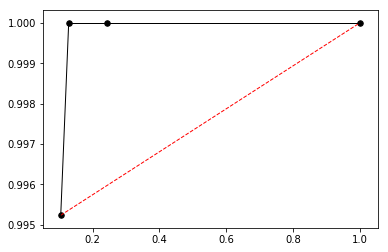




# Lexical task, font: inputsans


counts  frequencies
categories responses                             
word       Sure word           209.0     0.995238
           Probably word         0.0     0.000000
           Probably non-word     0.0     0.000000
           Sure non-word         1.0     0.004762
non-word   Sure word            25.0     0.119048
           Probably word         6.0     0.028571
           Probably non-word    15.0     0.071429
           Sure non-word       164.0     0.780952

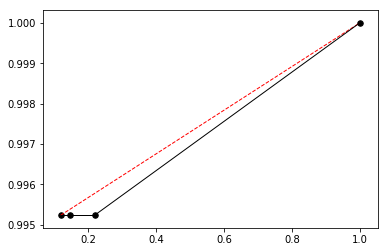




# Recognition task, font: sansforgetica


counts  frequencies
categories responses                             
seen       Sure seen              74     0.437870
           Probably seen          56     0.331361
           Probably not seen      30     0.177515
           Sure not seen           9     0.053254
non-seen   Sure seen              20     0.119760
           Probably seen          24     0.143713
           Probably not seen      61     0.365269
           Sure not seen          62     0.371257

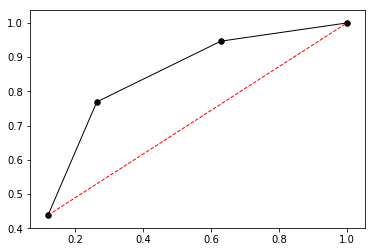




# Recognition task, font: inputsans


counts  frequencies
categories responses                             
seen       Sure seen              90     0.535714
           Probably seen          41     0.244048
           Probably not seen      31     0.184524
           Sure not seen           6     0.035714
non-seen   Sure seen              20     0.119048
           Probably seen          28     0.166667
           Probably not seen      56     0.333333
           Sure not seen          64     0.380952

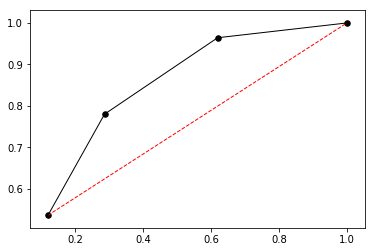

In [151]:
def cummulative(x):
    return [sum(x[0:i+1]) for i in range(len(x))]

def plot_roc(x, y):
    plt.plot((min(x), max(x)), (min(y), max(y)), color='red', linewidth=1, linestyle='--')
    for i in range(len(x)-1):
        plt.plot((x[i], x[i+1]), (y[i], y[i+1]), color='black', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker='o', s=30, color='black')
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.show()

fonts = set(d["Font"].unique())

for test_type in ["lexical", "recognition"]:
    if test_type == "lexical":
        category_used = "Category"
        categories = ["word", "non-word"]
        responses = ["Sure word", "Probably word", "Probably non-word", "Sure non-word"]
    else:
        category_used = "Seen"
        categories = ["seen", "non-seen"]
        responses = ["Sure seen", "Probably seen", "Probably not seen", "Sure not seen"]
    index = pd.MultiIndex.from_product([categories, responses], names=["categories", "responses"])
    for font in fonts:
        dt = d[(d["Test type"] == test_type) & (d["Font"] == font)]
        dg = pd.DataFrame(index=index)
        dg["counts"] = dt.groupby(category_used)["Response"].value_counts()
        dg["frequencies"] = dt.groupby(category_used)["Response"].value_counts(normalize=True)
        dg = dg.fillna(0)
        print("# %s task, font: %s" % (test_type.title(), font))
        display(dg)
        plot_roc(cummulative(dg["frequencies"].tolist()[4:]), cummulative(dg["frequencies"].tolist()[:4]))
        #print(get_auc((cummulative(dg["frequencies"].tolist()[4:]), cummulative(dg["frequencies"].tolist()[:4]))))
        print()
        print()
        print()

In [120]:
list(zip([0,1,2],[0,2,4]))

[(0, 0), (1, 2), (2, 4)]